# GEODOS data processing

In [158]:
import pandas as pd
import numpy as np
from datetime import datetime #, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [213]:
directory = '/storage/stations/Polednik/geodos/2021/10/10'
#directory = '/storage/stations/Polednik/geodos/2021/10/13'
#directory = '/storage/stations/Polednik/geodos/2021/10/EC'

fto = directory + '/DATALOG.TXT'

l=[]
l.extend(range(0,500))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
#df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

#!!!
#df.drop(df.index[:last[-1:][0]], inplace=True) # keep only last run

s.n.:  1290c00806a20091e412a000a0000010
f.v.:  51832f3
0         GEO2
68310     GEO2
68311     GEO2
68312     GEO2
68313     GEO2
          ... 
209368    GEO2
209369    GEO2
209370    GEO2
209371    GEO2
209372    GEO2
Name: 1, Length: 141064, dtype: object
209373
209372


## Fill position and time by GPS NMEA records

In [214]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

0          1           2                                 3  \
1      $GNVTG       GEO2           T  1290c00806a20091e412a000a0000010   
2      $GNGGA  143208.00  4903.84979                                 N   
3      $GNGSA          A           3                                03   
4      $GNGSA          A           3                                03   
5      $GPGSV          4           1                                14   
...       ...        ...         ...                               ...   
68305   $HITS          4      101776                                56   
68306   $HIST      30808   502068.73                          86634.75   
68307   $HITS          3      209350                                10   
68308   $HIST      30809   502084.67                          86647.50   
68309   $HITS          1       46850                                 9   

                 4      5       6      7       8       9  ... 499   flag  \
1                M  0.377       N  0.697       K       A  ... NaN    NaN   
2      01323.70453      E       1     09    1.01  1351.1  ... NaN    NaN   
3               04     22      01     17      19      09  ... NaN    NaN   
4               04     22      01     17      19      09  ... NaN    NaN   
5               01     42     150     32      03      71  ... NaN    NaN   
...            ...    ...     ...    ...     ...     ...  ...  ..    ...   
68305       118812      9  210650     10  229111      16  ... NaN  False   
68306         6.50  -0.26    -257   -257    -257   55524  ... NaN  False   
68307       258456     27  261942     13    -257   55524  ... NaN  False   
68308         6.50  -0.26    -257   -257    -257   54655  ... NaN  False   
68309         6.50  -0.26    -257   -257    -257   54655  ... NaN  False   

      on_miliseconds  miliseconds     alt        lat        lon  \
1                NaN          NaN     NaN        NaN        NaN   
2                NaN          NaN  1351.1        NaN        NaN   
3                NaN          NaN  1351.1        NaN        NaN   
4                NaN          NaN  1351.1        NaN        NaN   
5                NaN          NaN  1351.1        NaN        NaN   
...              ...          ...     ...        ...        ...   
68305    501129240.0  502052810.0  1351.4  49.064121  13.395117   
68306    501129240.0  502068730.0  1351.4  49.064121  13.395117   
68307    501129240.0  502068730.0  1351.4  49.064121  13.395117   
68308    501129240.0  502084670.0  1351.4  49.064121  13.395117   
68309    501129240.0  502084670.0  1351.4  49.064121  13.395117   

                     date   meas                     UTC  
1                     NaT      1                     NaT  
2                     NaT      2                     NaT  
3                     NaT      3                     NaT  
4                     NaT      4                     NaT  
5                     NaT      5                     NaT  
...                   ...    ...                     ...  
68305 2021-08-18 09:44:17  68304 2021-08-18 09:59:40.570  
68306 2021-08-18 09:44:17  68306 2021-08-18 09:59:56.490  
68307 2021-08-18 09:44:17  68306 2021-08-18 09:59:56.490  
68308 2021-08-18 09:44:17  68308 2021-08-18 10:00:12.430  
68309 2021-08-18 09:44:17  68308 2021-08-18 10:00:12.430  

[67552 rows x 509 columns]

In [215]:
df = df.loc[df['UTC']>'2021-08-15 7:00:00'].loc[df['UTC']<'2021-08-16 23:59:00'] # 15. a 16.
#df = df.loc[df['UTC']>'2021-08-15 17:00:00'].loc[df['UTC']<'2021-08-15 18:40:00'] # jenom 15.
#df = df.loc[df['UTC']>'2021-08-15 17:00:00'].loc[df['UTC']<'2021-08-15 18:30:00'] # jenom 15.

## Add individual events to histogram

In [216]:
HISTHITS = 9 # Ratmirov
#HISTHITS = 28 # ABSjets
FIRSTCH = 2

df.dropna(subset=['date'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:9+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
hist['temperature'] = hist.loc[:,4]
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [217]:
events = pd.DataFrame(columns=['time', 'energy'])


try:
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            event_ch = hits.iloc[i,j*2+3]
            event_time = hits.iloc[i,j*2+2]
            #etime = hist.iloc[i].UTC - pd.Timedelta(microseconds=64*(65535*4-event_time))
            etime = hits.iloc[i].UTC - pd.Timedelta(microseconds=54*65535*4) + pd.Timedelta(microseconds=53*event_time)
            events = pd.concat([events, pd.DataFrame.from_records([{'time':etime, 'energy':event_ch}])])

except:
    print(i,j)
    raise
            
events.set_index('time', drop=False, inplace=True)
events.sort_index(inplace=True)

In [6]:
hist['temperature'] = hist.loc[:,4]

## Flux

In [218]:
histogram = hist

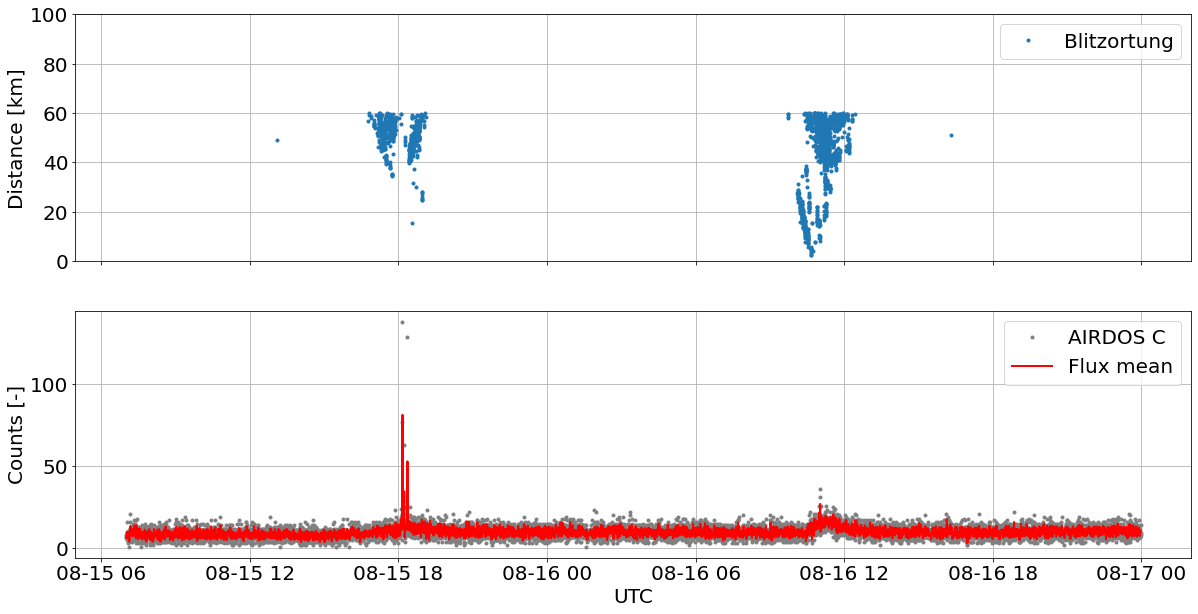

In [219]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 3

blitz = pd.read_csv(directory + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)
blitz.sort_index(inplace=True)
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz = blitz.loc[blitz['date']>'2021-08-15 16:00:00'].loc[blitz['date']<'2021-08-16 23:00:00']

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 17:45:00':'2021-7-25 19:00:00']
#blitz = blitz.loc['2021-7-25 18:00:00':'2021-7-25 18:20:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['flux1'] = (xx.iloc[:,range(NOISE_LEVEL,NOISE_LEVEL+2)].sum(axis=1))
#xx['flux2'] = (xx.iloc[:,range(NOISE_LEVEL+2,NOISE_LEVEL+7)].sum(axis=1))
#xx['flux3'] = (xx.iloc[:,range(NOISE_LEVEL+7,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax5) = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
matplotlib.rcParams.update({'font.size': 20})

ax5.plot(xx['flux'], c='gray', linestyle='', marker='.', label='AIRDOS C')
#ax5.plot(xx['flux1'], label='flux1')
#ax5.plot(xx['flux2'], label='flux2')
#ax5.plot(xx['flux3'], label='flux3')
ax5.plot(xx['fluxmean'], c='red', lw=2, label='Flux mean')
ax5.set_ylabel('Counts [-]')
ax5.set_xlabel('UTC')
#ax5.set_ylim(0,21)
ax5.legend()
#ax5.set_yscale('log')
ax5.grid()

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps['timeR'], ymin=0, ymax=130, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.legend()


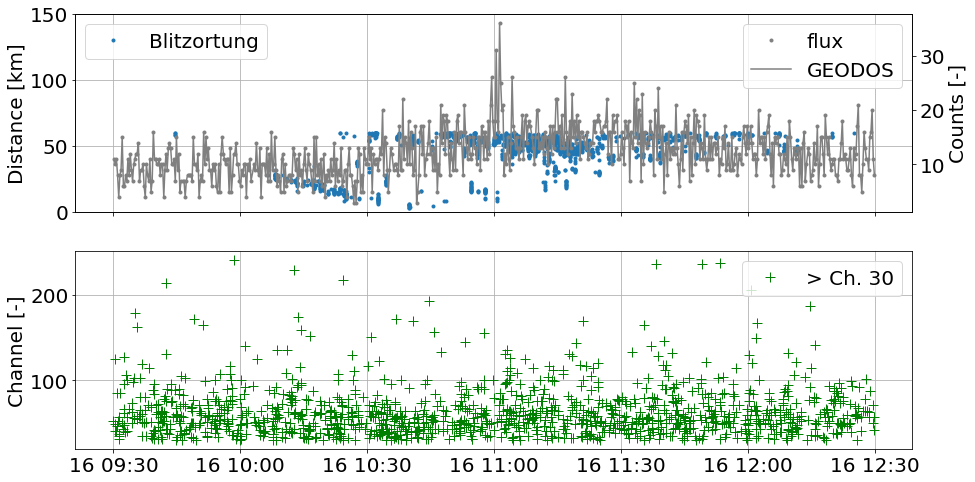

In [45]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 0:30:00'
TO = '2021-08-15 22:30:00'
FROM = '2021-08-16 9:30:00'
TO = '2021-08-16 12:30:00'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='', marker='.', label='flux')
ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]')
#ax5_twin.set_ylim(0,50)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,150)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=2)

ax2.plot(events_x.loc[events_x.energy>30].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.set_ylabel('Channel [-]')
ax2.grid()
#ax2.set_ylim(0,200)
ax2.legend(loc=1)


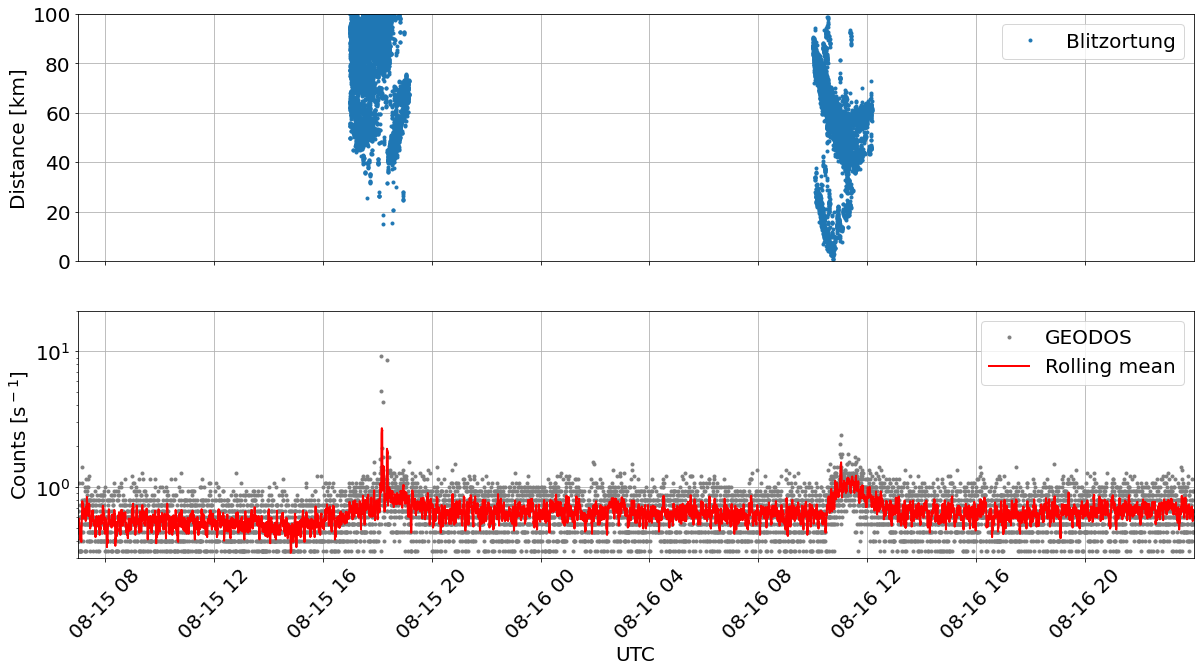

In [220]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 8

#blitz = pd.read_csv(directory + "/blitz.csv")
#'''
blitz = pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-15_Region1.csv')
blitz = pd.concat([blitz,pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-15_Region18.csv')])
blitz = pd.concat([blitz,pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-15_Region19.csv')])

blitz = pd.concat([blitz,pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-16_Region1.csv')])
blitz = pd.concat([blitz,pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-16_Region18.csv')])
blitz = pd.concat([blitz,pd.read_csv('/storage/stations/Polednik/geodos/2021/10/10/Polednik_2021-08-16_Region19.csv')])

blitz['date'] = pd.to_datetime(blitz['UTC'])
blitz.set_index('date', inplace=True)
blitz.sort_index(inplace=True)
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz = blitz.loc[blitz['date']>'2021-08-15 16:00:00'].loc[blitz['date']<'2021-08-16 23:00:00']

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-7-25 17:45:00':'2021-7-25 19:00:00']
xx = xx.loc['2021-08-15 06:00:00':'2021-08-17 00:00:00']
#blitz = blitz.loc['2021-7-25 18:00:00':'2021-7-25 18:20:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['flux1'] = (xx.iloc[:,range(NOISE_LEVEL,NOISE_LEVEL+2)].sum(axis=1))
#xx['flux2'] = (xx.iloc[:,range(NOISE_LEVEL+2,NOISE_LEVEL+7)].sum(axis=1))
#xx['flux3'] = (xx.iloc[:,range(NOISE_LEVEL+7,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax5) = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
matplotlib.rcParams.update({'font.size': 20})

ax5.plot(xx['flux']/15, c='gray', linestyle='', marker='.', label='GEODOS')
#ax5.plot(xx['flux1'], label='flux1')
#ax5.plot(xx['flux2'], label='flux2')
#ax5.plot(xx['flux3'], label='flux3')
ax5.plot(xx['fluxmean']/15, c='red', lw=2, label='Rolling mean')
ax5.set_ylabel('Counts [s$^-$$^1$]')
ax5.set_xlabel('UTC')
ax5.set_ylim(0.3,20)
ax5.legend()
ax5.set_yscale('log')
#ax5.grid(which='minor', color='lightgray')
ax5.grid(which='major')

ax6.plot(blitz.date, blitz.km, ls='', marker='.', label='Blitzortung')
ax6.set_ylabel('Distance [km]')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps['timeR'], ymin=0, ymax=130, color='red', label='Trigger STP', lw=1, linestyle='-', alpha=0.3)
ax6.legend()

ax5.margins(x=0)
ax6.margins(x=0)
ax5.tick_params(axis='x', labelrotation=45)

plt.savefig("Fig4.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [141]:
xx

0      1          2         3      4     5    6  \
UTC                                                                            
2021-08-15 06:00:00.440  $HIST  13990  228478.40  87019.00  17.56  4.07  -15   
2021-08-15 06:00:16.190  $HIST  13991  228494.15  87022.00  17.56  4.07  -15   
2021-08-15 06:00:32.280  $HIST  13992  228510.24  87021.25  17.56  4.07  -15   
2021-08-15 06:00:48.400  $HIST  13993  228526.36  87020.75  17.56  4.07  -15   
2021-08-15 06:01:04.500  $HIST  13994  228542.46  87020.50  17.56  4.07  -14   
...                        ...    ...        ...       ...    ...   ...  ...   
2021-08-16 23:58:43.670  $HIST  23209  379599.11  86369.00   6.56 -0.26 -257   
2021-08-16 23:59:00.060  $HIST  23210  379615.50  86399.50   6.56 -0.26 -257   
2021-08-16 23:59:15.540  $HIST  23211  379630.98  86342.75   6.56 -0.26 -257   
2021-08-16 23:59:31.470  $HIST  23212  379646.91  86346.25   6.56 -0.26 -257   
2021-08-16 23:59:47.470  $HIST  23213  379662.91  86344.25   6.56 -0.26 -257   

                           7    8      9  ...   15   16   17     alt  \
UTC                                       ...                          
2021-08-15 06:00:00.440  703  890  36076  ...  1.0  1.0  2.0  1352.9   
2021-08-15 06:00:16.190  703  890  32155  ...  0.0  1.0  1.0  1352.9   
2021-08-15 06:00:32.280  703  890  31241  ...  1.0  1.0  2.0  1352.9   
2021-08-15 06:00:48.400  703  890  30349  ...  2.0  2.0  1.0  1352.9   
2021-08-15 06:01:04.500  703  890  35281  ...  0.0  1.0  0.0  1352.9   
...                      ...  ...    ...  ...  ...  ...  ...     ...   
2021-08-16 23:58:43.670 -257 -257  57070  ...  0.0  1.0  2.0  1324.9   
2021-08-16 23:59:00.060 -257 -257  53645  ...  2.0  0.0  0.0  1324.9   
2021-08-16 23:59:15.540 -257 -257  51620  ...  0.0  0.0  0.0  1324.9   
2021-08-16 23:59:31.470 -257 -257  55609  ...  2.0  1.0  1.0  1324.9   
2021-08-16 23:59:47.470 -257 -257  62793  ...  1.0  0.0  0.0  1324.9   

                               lat        lon                     UTC  \
UTC                                                                     
2021-08-15 06:00:00.440  49.064070  13.395073 2021-08-15 06:00:00.440   
2021-08-15 06:00:16.190  49.064070  13.395073 2021-08-15 06:00:16.190   
2021-08-15 06:00:32.280  49.064070  13.395073 2021-08-15 06:00:32.280   
2021-08-15 06:00:48.400  49.064070  13.395073 2021-08-15 06:00:48.400   
2021-08-15 06:01:04.500  49.064070  13.395073 2021-08-15 06:01:04.500   
...                            ...        ...                     ...   
2021-08-16 23:58:43.670  49.064121  13.395184 2021-08-16 23:58:43.670   
2021-08-16 23:59:00.060  49.064121  13.395184 2021-08-16 23:59:00.060   
2021-08-16 23:59:15.540  49.064121  13.395184 2021-08-16 23:59:15.540   
2021-08-16 23:59:31.470  49.064121  13.395184 2021-08-16 23:59:31.470   
2021-08-16 23:59:47.470  49.064121  13.395184 2021-08-16 23:59:47.470   

                         temperature  flux  fluxmean  
UTC                                                   
2021-08-15 06:00:00.440        17.56   8.0       NaN  
2021-08-15 06:00:16.190        17.56   8.0       NaN  
2021-08-15 06:00:32.280        17.56  12.0       NaN  
2021-08-15 06:00:48.400        17.56  12.0       NaN  
2021-08-15 06:01:04.500        17.56   6.0       NaN  
...                              ...   ...       ...  
2021-08-16 23:58:43.670         6.56   8.0       9.3  
2021-08-16 23:59:00.060         6.56  12.0       9.8  
2021-08-16 23:59:15.540         6.56   3.0       9.4  
2021-08-16 23:59:31.470         6.56  16.0      10.1  
2021-08-16 23:59:47.470         6.56  12.0      10.3  

[9222 rows x 25 columns]

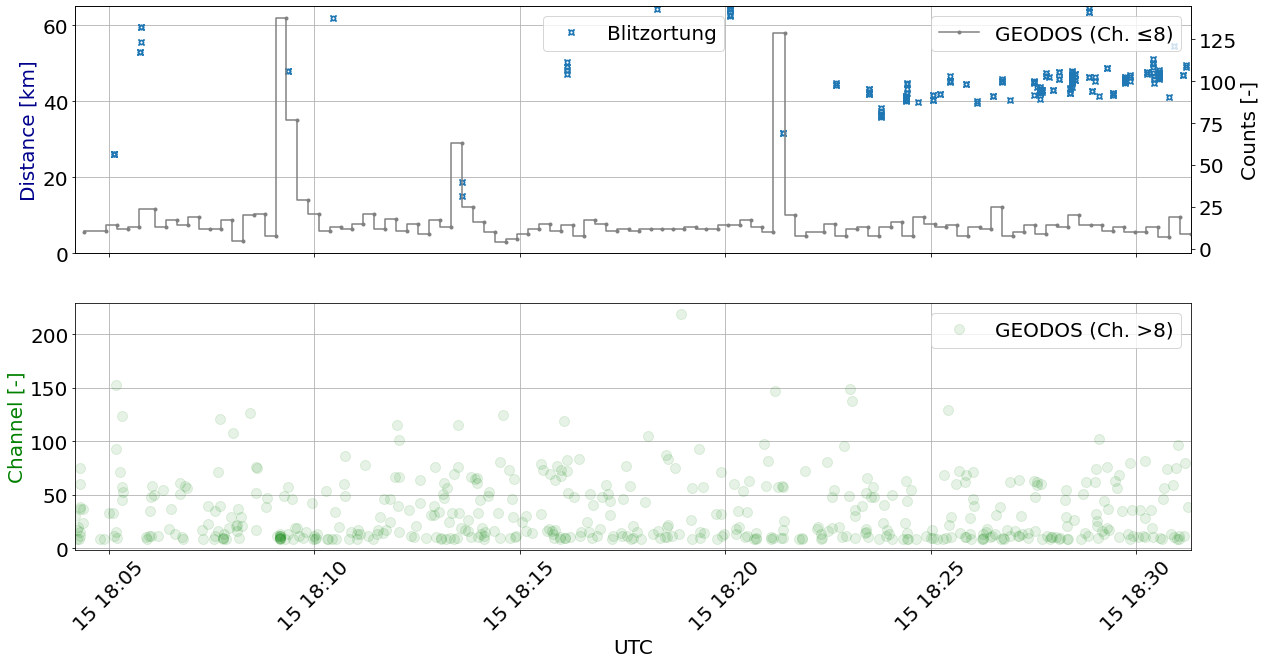

In [221]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:04:10'
TO = '2021-08-15 18:31:20'
#FROM = '2021-08-15 18:09:00'
#TO = '2021-08-15 18:10:00'
#FROM = '2021-08-16 10:55:30'
#TO = '2021-08-16 11:15:20'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,8), facecolor='lightyellow')
fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
ax5_twin = ax6.twinx()

ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='GEODOS (Ch. ≤8)', drawstyle='steps-pre')
#ax5_twin.plot(xx['flux'], c='gray', label='GEODOS')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]', color='black')
#ax5.set_ylim(0,21)
ax5_twin.legend()
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='$🗲$', label='Blitzortung')
ax6.set_ylabel('Distance [km]', color='darkblue')
ax6.set_ylim(0,65)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=9)
#ax6.legend()

#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=10, marker='o', color='green', label='GEODOS (Ch. >8)', alpha=0.1)
ax2.set_ylabel('Channel [-]', color='green')
ax2.grid()
#ax2.set_ylim(7,40)
ax2.legend(loc=1)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 45)

ax2.margins(x=0)
ax6.margins(x=0)
ax2_twin.margins(x=0)
ax5_twin.margins(x=0)

plt.savefig("Fig8.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

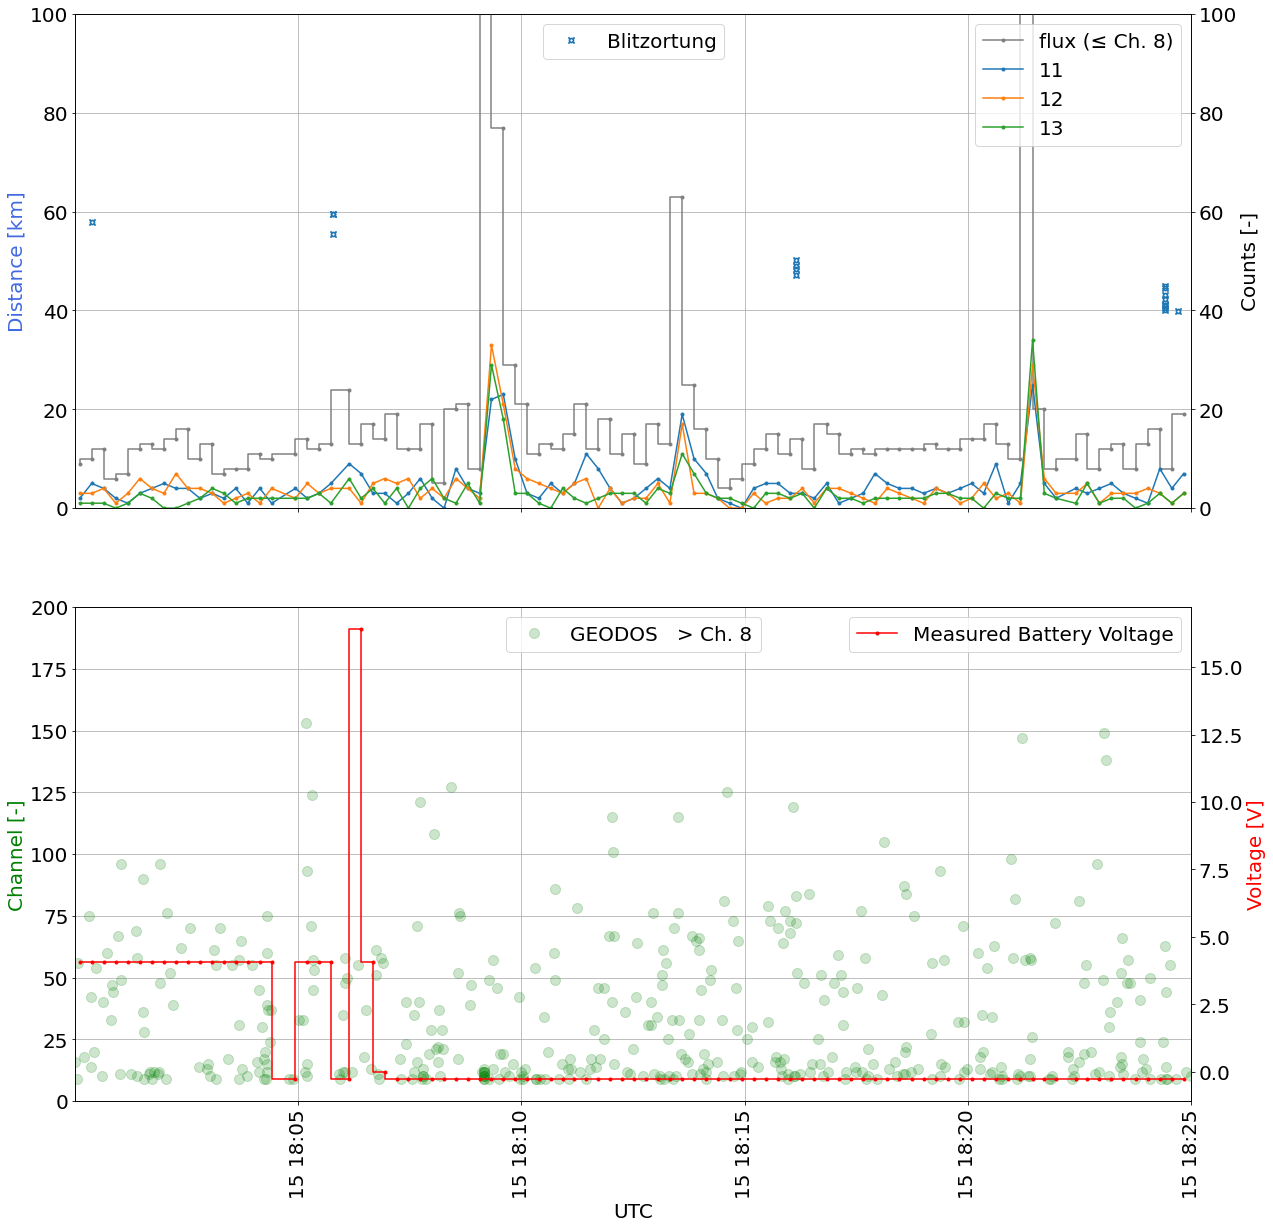

In [85]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:00:00'
TO = '2021-08-15 18:25:00'
#FROM = '2021-08-15 18:08:55' # 1st peak
#TO = '2021-08-15 18:10:25'
#FROM = '2021-08-16 10:55:30'
#TO = '2021-08-16 11:15:20'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,20))
ax5_twin = ax6.twinx()
ax2_twin = ax2.twinx()

ax2.autoscale(tight=True)
ax6.autoscale(tight=True)


ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='flux (≤ Ch. 8)', drawstyle='steps-pre')
ax5_twin.plot(xx.iloc[:,11], label='11', marker='.')
#ax5_twin.plot((xx.iloc[:,12]+xx.iloc[:,13])/2, label='12-13', marker='.', drawstyle='steps-mid')
ax5_twin.plot(xx.iloc[:,12], label='12', marker='.')
ax5_twin.plot(xx.iloc[:,13], label='13', marker='.')
#ax5_twin.plot((xx.iloc[:,14]+xx.iloc[:,15]+xx.iloc[:,16]+xx.iloc[:,17])/4, label='14-17', marker='.', drawstyle='steps-mid')
#ax5_twin.plot(xx.iloc[:,14], label='14', marker='.')
#ax5_twin.plot(xx.iloc[:,15], label='15', marker='.')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]')
ax5_twin.set_ylim(0,100)
ax5_twin.legend(loc=1)
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='$🗲$', label='Blitzortung')
ax6.set_ylabel('Distance [km]', color='royalblue')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=9)

#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=20, marker='.', color='green', label='GEODOS   > Ch. 8', alpha=0.2)
ax2.set_ylabel('Channel [-]', color='green')
ax2.grid()
ax2.set_ylim(0,200)
ax2.legend(loc=9)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 90)

ax2_twin.plot(xx[5], linestyle='-', color='red', marker='.', label='Measured Battery Voltage', drawstyle='steps-pre')
ax2_twin.set_ylabel('Voltage [V]', color='red')
ax2_twin.legend()

ax2.margins(x=0)
ax6.margins(x=0)
ax2_twin.margins(x=0)
ax5_twin.margins(x=0)


#events_x['mean'] = events_x['energy'].rolling(50).mean()
#ax2_twin.plot(events_x['mean'])


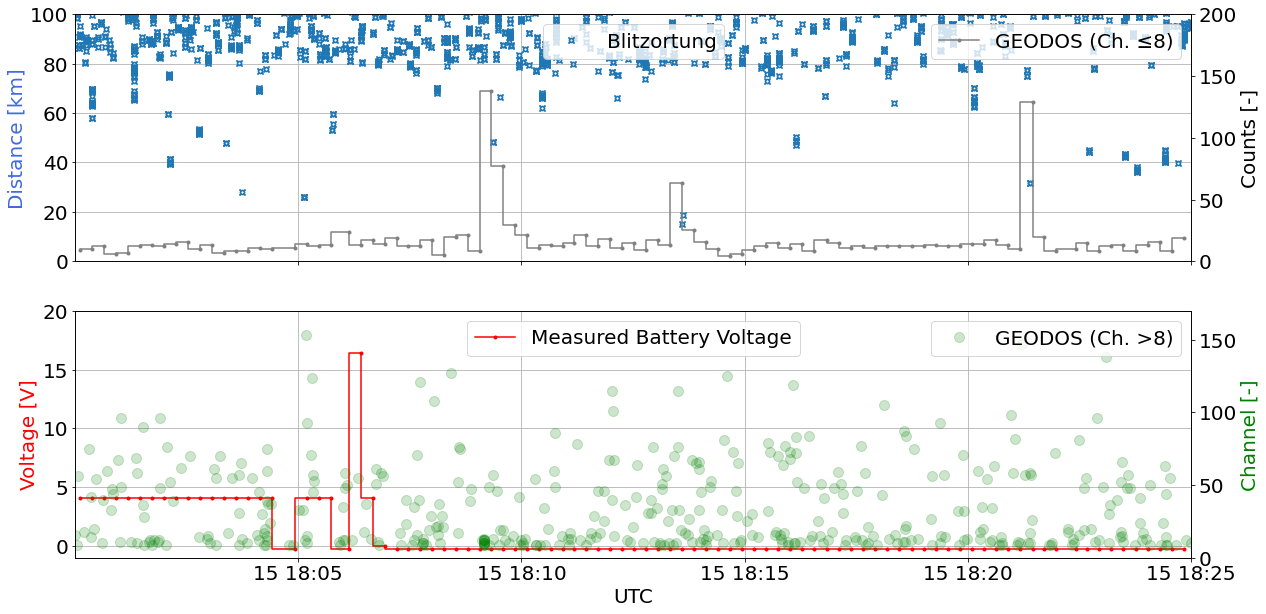

In [222]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:00:00'
TO = '2021-08-15 18:25:00'
#FROM = '2021-08-15 18:08:55' # 1st peak
#TO = '2021-08-15 18:10:25'
#FROM = '2021-08-16 10:55:30'
#TO = '2021-08-16 11:15:20'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, (ax6, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,10))
ax5_twin = ax6.twinx()
ax2_twin = ax2.twinx()

ax2.autoscale(tight=True)
ax6.autoscale(tight=True)


ax5_twin.plot(xx['flux'], c='gray', linestyle='-', marker='.', label='GEODOS (Ch. ≤8)', drawstyle='steps-pre')
#ax5_twin.plot(xx.iloc[:,11], label='11', marker='.')
#ax5_twin.plot((xx.iloc[:,12]+xx.iloc[:,13])/2, label='12-13', marker='.', drawstyle='steps-mid')
#ax5_twin.plot(xx.iloc[:,12], label='12', marker='.')
#ax5_twin.plot(xx.iloc[:,13], label='13', marker='.')
#ax5_twin.plot((xx.iloc[:,14]+xx.iloc[:,15]+xx.iloc[:,16]+xx.iloc[:,17])/4, label='14-17', marker='.', drawstyle='steps-mid')
#ax5_twin.plot(xx.iloc[:,14], label='14', marker='.')
#ax5_twin.plot(xx.iloc[:,15], label='15', marker='.')
#ax5_twin.plot(xx['fluxmean'], c='gray', label='Geodos avg')
ax5_twin.set_ylabel('Counts [-]')
ax5_twin.set_ylim(0,200)
ax5_twin.legend(loc=1)
#ax5.set_yscale('log')
#ax5_twin.grid()
#ax5.set_xlabel('UTC')

ax6.plot(blitz_x.date, blitz_x.km, ls='', marker='$🗲$', label='Blitzortung')
ax6.set_ylabel('Distance [km]', color='royalblue')
ax6.set_ylim(0,100)
ax6.grid()
#ax6.vlines(x=gps_x['timeR'], ymin=0, ymax=150, color='red', label='Trigger', lw=1, alpha=0.5)
ax6.legend(loc=9)

#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2_twin.plot(events_x.energy, ls='', ms=20, marker='.', color='green', label='GEODOS (Ch. >8)', alpha=0.2)
ax2_twin.set_ylabel('Channel [-]', color='green')
#ax2_twin.grid()
ax2_twin.set_ylim(0,170)
ax2_twin.legend(loc=1)
ax2_twin.set_xlabel('UTC')
ax2_twin.tick_params(axis='x', labelrotation = 90)

ax2.plot(xx[5], linestyle='-', color='red', marker='.', label='Measured Battery Voltage', drawstyle='steps-pre')
ax2.set_ylabel('Voltage [V]', color='red')
ax2.set_ylim(-1,20)
ax2.legend(loc=9)
ax2.grid()
ax2.set_xlabel('UTC')

ax2.margins(x=0)
ax6.margins(x=0)
ax2_twin.margins(x=0)
ax5_twin.margins(x=0)


#events_x['mean'] = events_x['energy'].rolling(50).mean()
#ax2_twin.plot(events_x['mean'])

plt.savefig("Fig12.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

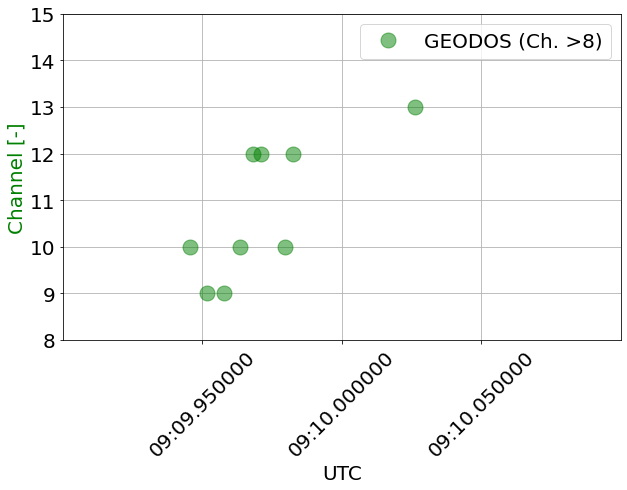

In [223]:
NOISE_LEVEL = 11
LAST_CHANNEL = 18
WINDOW = 20

xx = histogram
xx.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:00:00'
TO = '2021-08-15 18:25:00'
#FROM = '2021-08-15 18:08:55' # 1st peak
#TO = '2021-08-15 18:10:25'
#FROM = '2021-08-16 10:55:30'
#TO = '2021-08-16 11:15:20'

xx = xx.loc[FROM:TO].copy()
blitz_x = blitz.loc[FROM:TO].copy()
events_x = events.loc[FROM:TO].copy()

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

#xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

fig, ( ax2) = plt.subplots(nrows=1, sharex=True, figsize=(10,6))
#ax2_twin = ax2.twinx()

ax2.autoscale(tight=True)

#ax2.plot(events_x.loc[events_x.energy>0].energy, ls='', ms=10, marker='+', color='green', label='> Ch. 30')
ax2.plot(events_x.energy, ls='', ms=30, marker='.', color='green', label='GEODOS (Ch. >8)', alpha=0.5)
ax2.set_ylabel('Channel [-]', color='green')
ax2.grid()
ax2.set_ylim(8,15)
ax2.legend(loc=1)
ax2.set_xlabel('UTC')
ax2.tick_params(axis='x', labelrotation = 45)

ax2.set_xlim(pd.to_datetime('2021-08-15 18:09:09.90'),pd.to_datetime('2021-08-15 18:09:10.10'))

ax2.margins(x=0)
ax6.margins(x=0)
ax2_twin.margins(x=0)
ax5_twin.margins(x=0)


#events_x['mean'] = events_x['energy'].rolling(50).mean()
#ax2_twin.plot(events_x['mean'])

plt.savefig("Fig10.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


In [121]:
xx

0      1          2         3      4     5    6  \
UTC                                                                            
2021-08-15 18:00:06.550  $HIST  16628  271683.88  86737.50  16.94  4.08  -65   
2021-08-15 18:00:22.420  $HIST  16629  271699.75  86747.50  16.88  4.08  -65   
2021-08-15 18:00:38.600  $HIST  16630  271715.93  86737.75  16.88  4.08  -65   
2021-08-15 18:00:54.770  $HIST  16631  271732.10  86754.75  16.81  4.08  -65   
2021-08-15 18:01:10.960  $HIST  16632  271748.29  86747.50  16.81  4.08  -65   
...                        ...    ...        ...       ...    ...   ...  ...   
2021-08-15 18:23:45.140  $HIST  16715  273102.47  86648.25  14.13 -0.26 -257   
2021-08-15 18:24:01.610  $HIST  16716  273118.94  86655.50  14.13 -0.26 -257   
2021-08-15 18:24:17.780  $HIST  16717  273135.11  86652.50  14.13 -0.26 -257   
2021-08-15 18:24:33.950  $HIST  16718  273151.28  86629.75  14.06 -0.26 -257   
2021-08-15 18:24:49.840  $HIST  16719  273167.17  86558.00  14.13 -0.26 -257   

                           7    8      9  ...   15   16   17     alt  \
UTC                                       ...                          
2021-08-15 18:00:06.550  833  881  10183  ...  0.0  0.0  0.0  1333.3   
2021-08-15 18:00:22.420  833  881  10654  ...  1.0  0.0  0.0  1333.3   
2021-08-15 18:00:38.600  833  881  13347  ...  2.0  0.0  0.0  1333.3   
2021-08-15 18:00:54.770  832  881   7902  ...  2.0  0.0  1.0  1333.3   
2021-08-15 18:01:10.960  832  881   9396  ...  0.0  2.0  0.0  1333.3   
...                      ...  ...    ...  ...  ...  ...  ...     ...   
2021-08-15 18:23:45.140 -257 -257  31280  ...  1.0  0.0  0.0  1343.3   
2021-08-15 18:24:01.610 -257 -257  29620  ...  3.0  2.0  0.0  1343.3   
2021-08-15 18:24:17.780 -257 -257  30739  ...  0.0  0.0  1.0  1343.3   
2021-08-15 18:24:33.950 -257 -257  29102  ...  0.0  1.0  0.0  1343.3   
2021-08-15 18:24:49.840 -257 -257  35314  ...  2.0  1.0  2.0  1343.3   

                               lat        lon                     UTC  \
UTC                                                                     
2021-08-15 18:00:06.550  49.064127  13.395212 2021-08-15 18:00:06.550   
2021-08-15 18:00:22.420  49.064127  13.395212 2021-08-15 18:00:22.420   
2021-08-15 18:00:38.600  49.064127  13.395212 2021-08-15 18:00:38.600   
2021-08-15 18:00:54.770  49.064127  13.395212 2021-08-15 18:00:54.770   
2021-08-15 18:01:10.960  49.064127  13.395212 2021-08-15 18:01:10.960   
...                            ...        ...                     ...   
2021-08-15 18:23:45.140  49.064127  13.395212 2021-08-15 18:23:45.140   
2021-08-15 18:24:01.610  49.064127  13.395212 2021-08-15 18:24:01.610   
2021-08-15 18:24:17.780  49.064127  13.395212 2021-08-15 18:24:17.780   
2021-08-15 18:24:33.950  49.064127  13.395212 2021-08-15 18:24:33.950   
2021-08-15 18:24:49.840  49.064127  13.395212 2021-08-15 18:24:49.840   

                         temperature  flux   fluxmean  
UTC                                                    
2021-08-15 18:00:06.550        16.94   9.0   7.333333  
2021-08-15 18:00:22.420        16.88  10.0   7.333333  
2021-08-15 18:00:38.600        16.88  12.0  10.333333  
2021-08-15 18:00:54.770        16.81   6.0   9.333333  
2021-08-15 18:01:10.960        16.81   7.0   8.333333  
...                              ...   ...        ...  
2021-08-15 18:23:45.140        14.13   8.0  11.000000  
2021-08-15 18:24:01.610        14.13  13.0  11.333333  
2021-08-15 18:24:17.780        14.13  16.0  12.333333  
2021-08-15 18:24:33.950        14.06   8.0  12.333333  
2021-08-15 18:24:49.840        14.13  19.0  14.333333  

[91 rows x 25 columns]

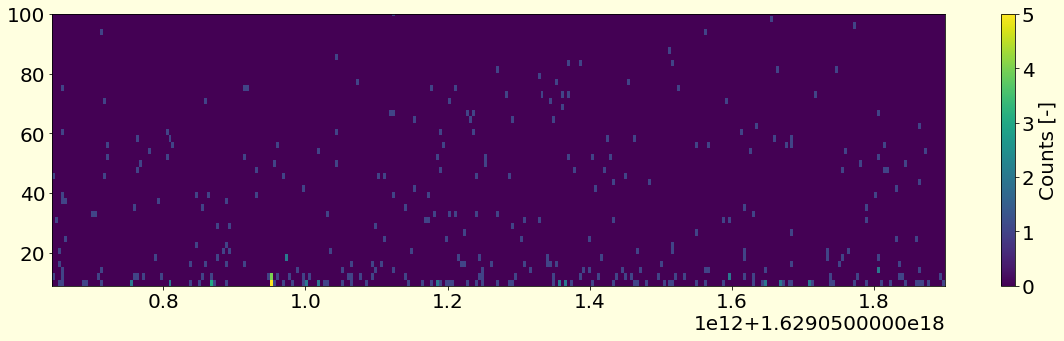

In [12]:
plt.figure(figsize=(20,5), facecolor='lightyellow')

h = plt.hist2d(events_x.index,events_x.energy, bins=(300,100))
plt.ylim(9,100)
plt.colorbar(label='Counts [-]')


# --------------------------------------------------------------------------------- END

/tmp/ipykernel_20863/3024544145.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_20863/3024544145.py:33: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


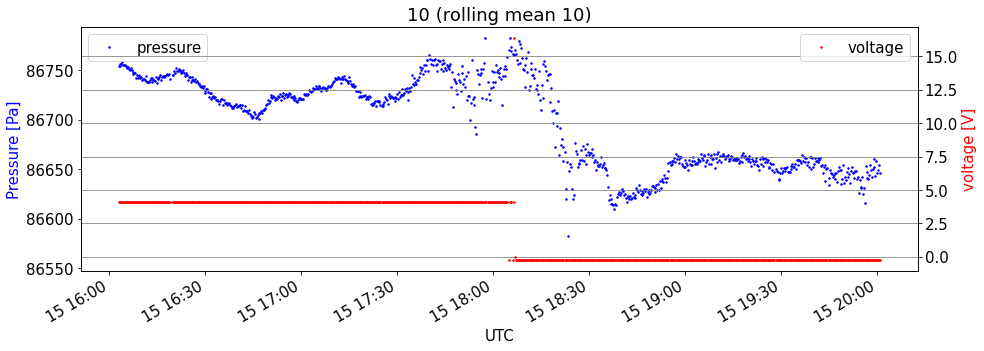

In [ ]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx[3].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx[5].plot(c='red', label='voltage', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('voltage [V]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_15512/283106060.py:21: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15512/283106060.py:22: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


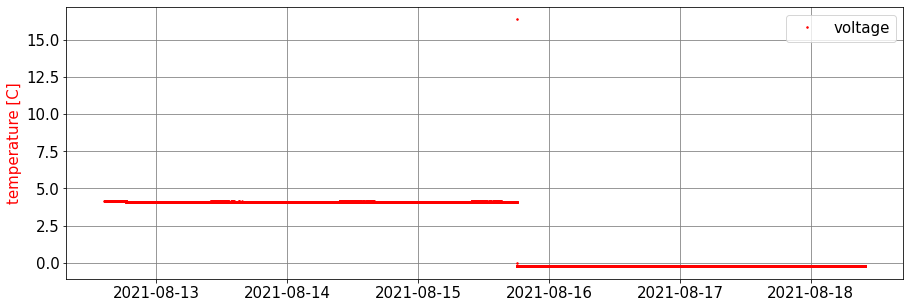

In [94]:
NOISE_LEVEL = 7
LAST_CHANNEL = 270
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = hist
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']

#plt.ylim([0,14000])
#plt.plot(xx.index, xx[2], c='red', label='time', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
#plt.plot(xx.index, xx[6], c='red', label='current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.plot(xx.index, xx[5], c='red', label='voltage', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



In [90]:
hist

0      1          2         3      4     5    6  \
UTC                                                                            
2021-08-12 14:32:25.080  $HIST      0      26.81  87376.50  23.13  4.16  -22   
2021-08-12 14:32:41.240  $HIST      1      42.97  87360.25  23.25  4.16  -17   
2021-08-12 14:32:57.400  $HIST      2      59.13  87357.00  23.38  4.16  -15   
2021-08-12 14:33:13.570  $HIST      3      75.30  87357.25  23.56  4.16  -15   
2021-08-12 14:33:29.430  $HIST      4      91.16  87356.50  23.63  4.16  -14   
...                        ...    ...        ...       ...    ...   ...  ...   
2021-08-18 09:59:08.720  $HIST  30805  502020.96  86654.00   6.44 -0.26 -257   
2021-08-18 09:59:24.640  $HIST  30806  502036.88  86639.50   6.44 -0.26 -257   
2021-08-18 09:59:40.570  $HIST  30807  502052.81  86625.75   6.44 -0.26 -257   
2021-08-18 09:59:56.490  $HIST  30808  502068.73  86634.75   6.50 -0.26 -257   
2021-08-18 10:00:12.430  $HIST  30809  502084.67  86647.50   6.50 -0.26 -257   

                           7    8      9  ...   15   16   17     alt  \
UTC                                       ...                          
2021-08-12 14:32:25.080  898  898  23198  ...  0.0  1.0  1.0  1351.1   
2021-08-12 14:32:41.240  898  898  19938  ...  2.0  2.0  1.0  1351.1   
2021-08-12 14:32:57.400  898  898  16221  ...  0.0  0.0  1.0  1351.1   
2021-08-12 14:33:13.570  898  898  17452  ...  1.0  1.0  0.0  1351.1   
2021-08-12 14:33:29.430  898  898  20549  ...  1.0  1.0  0.0  1351.1   
...                      ...  ...    ...  ...  ...  ...  ...     ...   
2021-08-18 09:59:08.720 -257 -257  57339  ...  0.0  2.0  0.0  1351.4   
2021-08-18 09:59:24.640 -257 -257  56530  ...  0.0  0.0  1.0  1351.4   
2021-08-18 09:59:40.570 -257 -257  56821  ...  1.0  1.0  0.0  1351.4   
2021-08-18 09:59:56.490 -257 -257  55524  ...  0.0  0.0  0.0  1351.4   
2021-08-18 10:00:12.430 -257 -257  54655  ...  1.0  0.0  0.0  1351.4   

                               lat        lon                     UTC  \
UTC                                                                     
2021-08-12 14:32:25.080  49.064136  13.395068 2021-08-12 14:32:25.080   
2021-08-12 14:32:41.240  49.064136  13.395068 2021-08-12 14:32:41.240   
2021-08-12 14:32:57.400  49.064136  13.395068 2021-08-12 14:32:57.400   
2021-08-12 14:33:13.570  49.064136  13.395068 2021-08-12 14:33:13.570   
2021-08-12 14:33:29.430  49.064136  13.395068 2021-08-12 14:33:29.430   
...                            ...        ...                     ...   
2021-08-18 09:59:08.720  49.064121  13.395117 2021-08-18 09:59:08.720   
2021-08-18 09:59:24.640  49.064121  13.395117 2021-08-18 09:59:24.640   
2021-08-18 09:59:40.570  49.064121  13.395117 2021-08-18 09:59:40.570   
2021-08-18 09:59:56.490  49.064121  13.395117 2021-08-18 09:59:56.490   
2021-08-18 10:00:12.430  49.064121  13.395117 2021-08-18 10:00:12.430   

                         temperature  flux   fluxmean  
UTC                                                    
2021-08-12 14:32:25.080        23.13   8.0        NaN  
2021-08-12 14:32:41.240        23.25  12.0        NaN  
2021-08-12 14:32:57.400        23.38   7.0   9.000000  
2021-08-12 14:33:13.570        23.56   9.0   9.333333  
2021-08-12 14:33:29.430        23.63   5.0   7.000000  
...                              ...   ...        ...  
2021-08-18 09:59:08.720         6.44   7.0   9.000000  
2021-08-18 09:59:24.640         6.44   9.0   9.333333  
2021-08-18 09:59:40.570         6.44   9.0   8.333333  
2021-08-18 09:59:56.490         6.50   9.0   9.000000  
2021-08-18 10:00:12.430         6.50  13.0  10.333333  

[30808 rows x 25 columns]

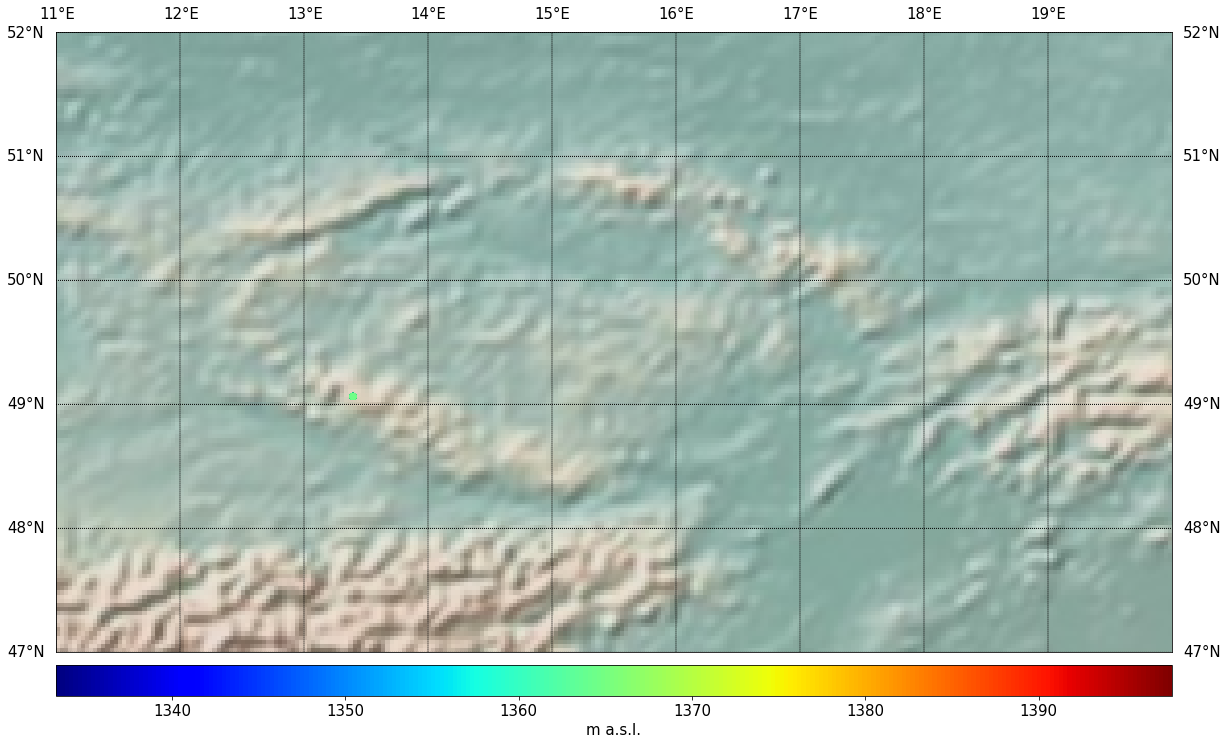

In [247]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import urllib, os

plt.figure(figsize=(20,20))
plt.tight_layout()

matplotlib.rcParams.update({'font.size': 15})

# create Basemap instance.
#m = Basemap(projection='kav7',lon_0=0)
m = Basemap(projection='cyl',lon_0=0, llcrnrlon=11,llcrnrlat=47,urcrnrlon=20,urcrnrlat=52)
#m = Basemap(projection='robin',lon_0=0)
#m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,projection='mill')

x, y = m(histogram.lon.tolist(),histogram.lat.tolist())
#m.drawmapboundary(fill_color='#99ffff')
#m.fillcontinents(color='#cc9966',lake_color='#99ffff',zorder=0)
# draw parallels and meridians, but don't bother labelling them.
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0])
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0])
m.shadedrelief()

im1 = m.scatter(x,y,c=hist.alt.tolist(),marker='o', cmap='jet')
cb = m.colorbar(im1,"bottom", size="5%", pad="2%")
cb.set_label('m a.s.l.')

#plt.clim(0, 12500)  # limit for color axis
plt.show()                


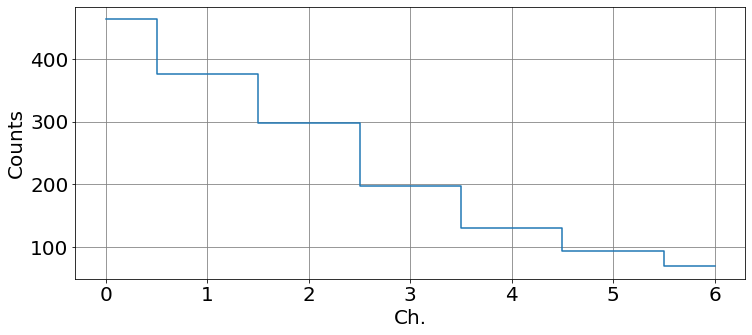

In [34]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc[FROM:TO]

#yy = yy.loc['2021-08-15 18:13:36':'2021-08-15 18:13:37']
#yy = yy.loc['2021-08-15 18:21:20':'2021-08-15 18:21:23']


#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
#yy = yy.loc['2021-8-3 16:45:00':'2021-8-3 16:48:00']
#yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,11:18].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
#plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

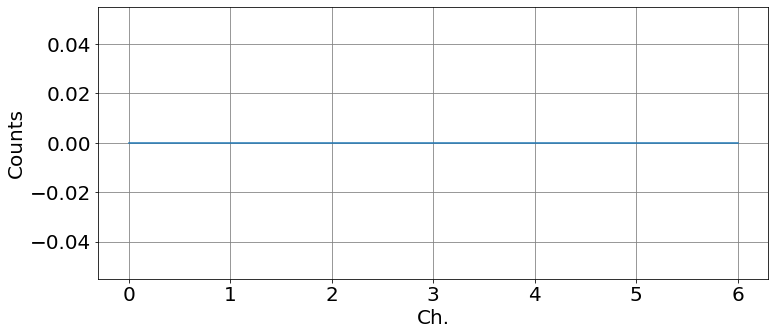

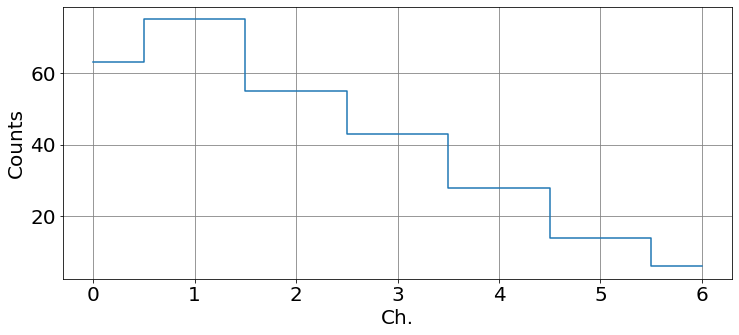

In [9]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:00:55' # 1st peak
TO = '2021-08-15 18:02:25'
yy = yy.loc[FROM:TO]
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,11:18].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
#plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:08:55' # 1st peak
TO = '2021-08-15 18:10:25'
yy = yy.loc[FROM:TO]
yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,11:18].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-mid')
#plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

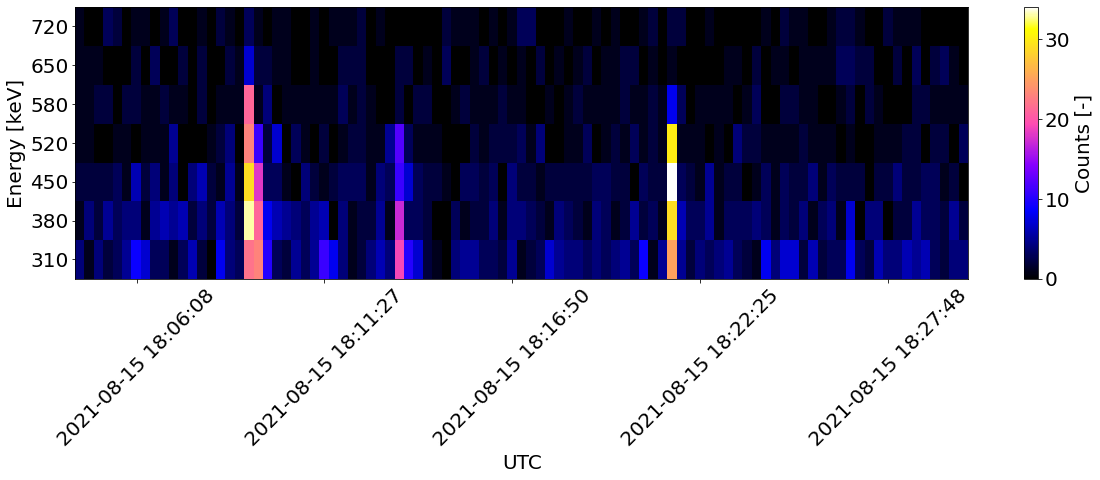

In [225]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

FROM = '2021-08-15 18:04:00' 
TO = '2021-08-15 18:30:00'
yy = yy.loc[FROM:TO]
#plt.figure(figsize=(20,5), facecolor='lightyellow')
plt.figure(figsize=(20,5))

#orig_map=plt.cm.get_cmap('gnuplot2')
#reversed_map = orig_map.reversed()

plt.imshow( yy.iloc[:,11:18].T, aspect='auto', origin='lower', cmap = 'gnuplot2')#, norm=colors.LogNorm()) # , cmap = 'autumn') 
plt.ylabel('Energy [keV]')
plt.xlabel('UTC')
plt.colorbar(label='Counts [-]')
x1 = [6,26,46,66,86]
squad = [str(yy.iloc[x1[0]].UTC.round(freq='S')),str(yy.iloc[x1[1]].UTC.round(freq='S')),str(yy.iloc[x1[2]].UTC.round(freq='S')),str(yy.iloc[x1[3]].UTC.round(freq='S')),str(yy.iloc[x1[4]].UTC.round(freq='S'))]
plt.xticks(x1, squad, rotation=45)

y1 = list(range(0,7))
y2 = ['']*7
for i in range(len(y1)):  
    y2[i] = str(int(round(68.04*y1[i]+260.13+68-17,-1)))
    #y2[i] = str(round(113.2*y1[i]+473.46))
plt.yticks(y1, y2, rotation=0)

plt.savefig("Fig9.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


Text(0, 0.5, 'Counts Low Channels')

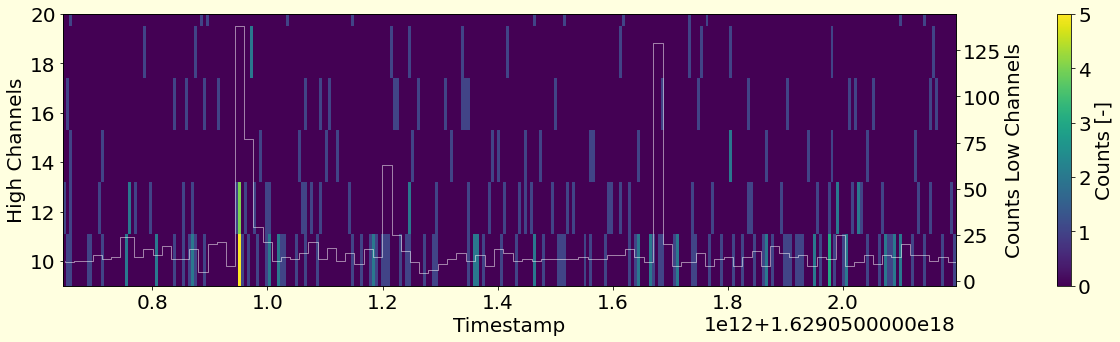

In [17]:
plt.figure(figsize=(20,5), facecolor='lightyellow')

events_x = events.loc[FROM:TO].copy()
#events_x = events_x.sort_index()
#events_xx = events_x.reset_index(drop=True)

#events_x.index.strftime('%r')

h = plt.hist2d(events_x.index,events_x.energy, bins=(300,100))
plt.ylim(9,20)
plt.colorbar(label='Counts [-]', anchor=(0.3, 0))
plt.ylabel('High Channels')
plt.xlabel('Timestamp')
plt.twinx()
plt.plot(yy.index.astype('int64'),yy.flux, drawstyle='steps-pre', color='white', linewidth=0.5)
plt.ylabel('Counts Low Channels')


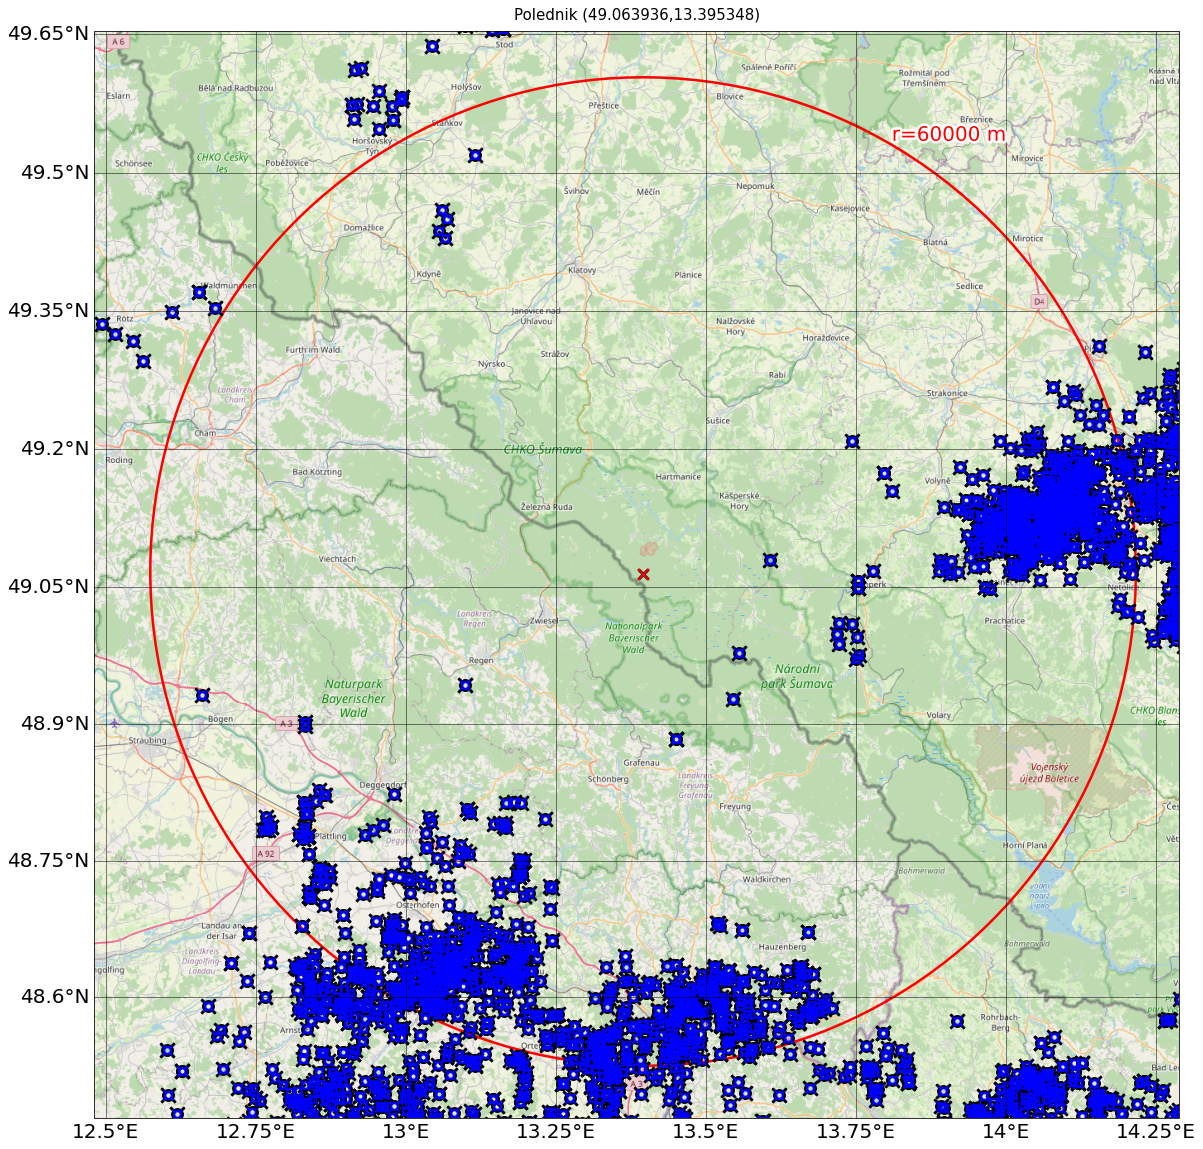

In [48]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3

    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=60000, npoints=0)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    if npoints>0: 
        # set random azimuth angles (seed for reproducablity)
        np.random.seed(1235)
        rand_azimuths_deg = np.random.random(npoints)*360

        # set random distances (seed for reproducablity)
        np.random.seed(6341)
        rand_distances = radius*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

        rand_lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
        rand_lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]

        ax.plot(rand_lon,rand_lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
        ax.plot(rand_lon,rand_lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz.loc['2021-08-15 14:00:00':'2021-08-15 20:00:00']
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

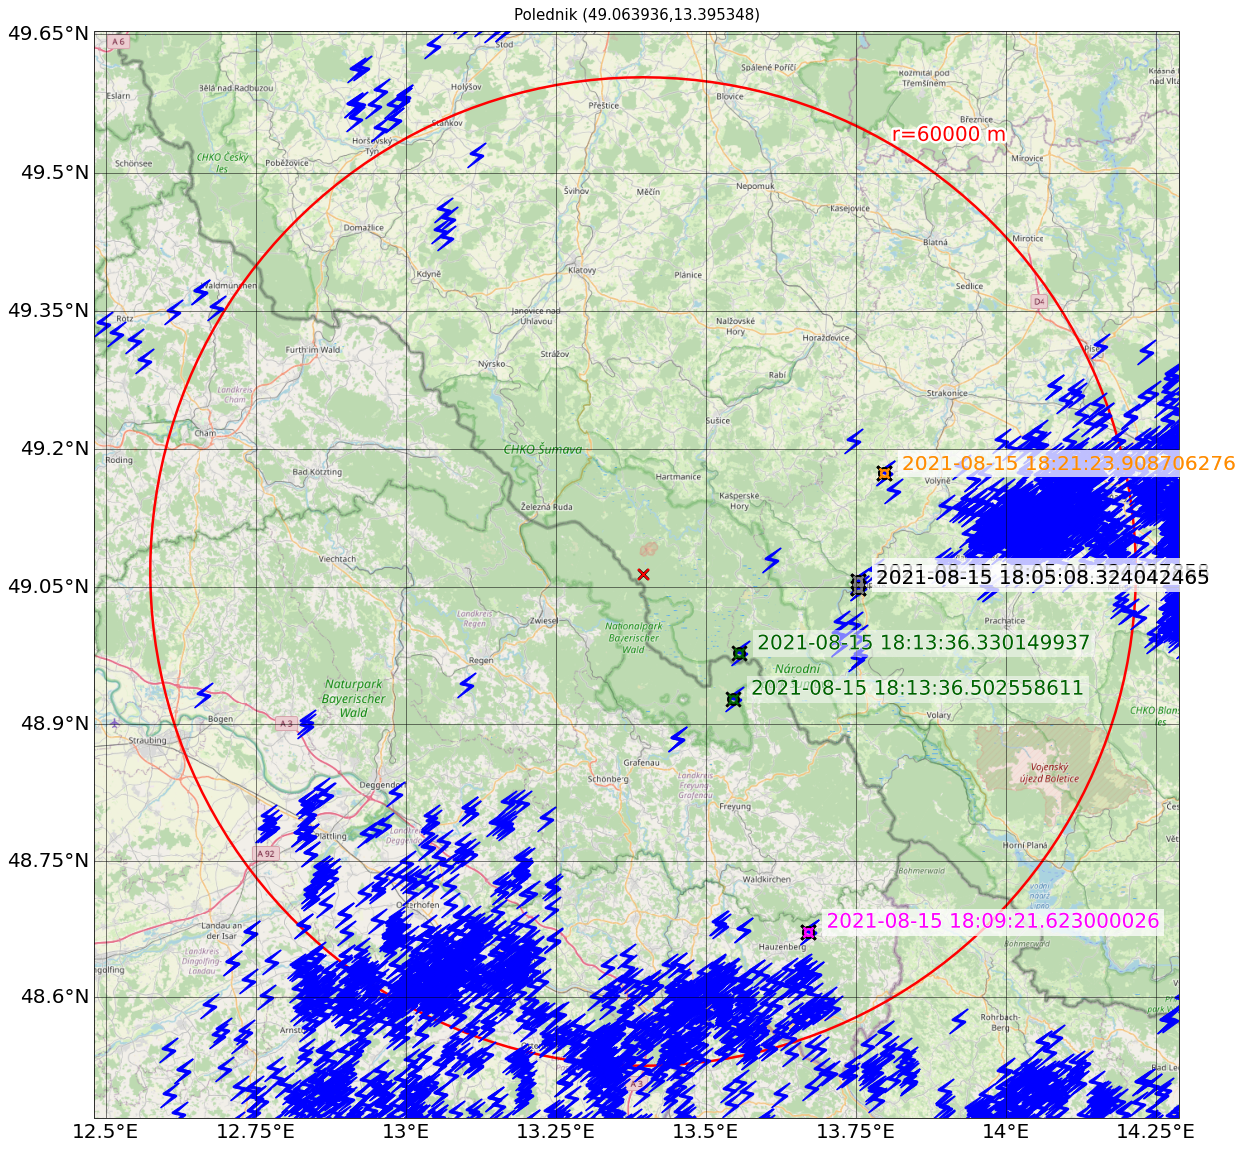

In [212]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'


def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500,npoints=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    scale = int(120/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    if npoints>0: 
        # set random azimuth angles (seed for reproducablity)
        np.random.seed(1235)
        rand_azimuths_deg = np.random.random(npoints)*360

        # set random distances (seed for reproducablity)
        np.random.seed(6341)
        rand_distances = radius*np.sqrt((np.random.random(npoints))) # np.random.uniform(low=0, high=radius, size=npoints)

        rand_lon = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,0]
        rand_lat = cgeo.Geodesic().direct((lon,lat),rand_azimuths_deg,rand_distances)[:,1]

        ax.plot(rand_lon,rand_lat,color='black',lw=0,marker='x',ms=4.5,mew=1.0,transform=data_crs)
        ax.plot(rand_lon,rand_lat,color='yellow',lw=0,marker='x',ms=4,mew=0.5,transform=data_crs)

    lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    lightning = blitz.loc['2021-08-15 18:09:19':'2021-08-15 18:9:22']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='magenta',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.03, row.lat, row.UTC, color='magenta', fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    lightning = blitz.loc['2021-08-15 18:13:36':'2021-08-15 18:13:37']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='darkgreen',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.03, row.lat, row.UTC, color='darkgreen', fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    lightning = blitz.loc['2021-08-15 18:21:20':'2021-08-15 18:21:23']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='darkorange',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.03, row.lat, row.UTC, color='darkorange', fontsize=20, ha='left',va='bottom', transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))
    
    lightning = blitz.loc['2021-08-15 18:05:08':'2021-08-15 18:05:08.40']
    ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$🗲$',ms=15,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='gray',lw=0,marker='$🗲$',ms=10,mew=1.0,transform=data_crs)
    for index, row in lightning.iterrows():
        t = ax.text(row.lon+0.03, row.lat, row.UTC, color='black', fontsize=20, ha='left',va='bottom', transform=data_crs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))
    
    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.savefig("Fig11.pdf", format="pdf", dpi=300, bbox_inches="tight")
    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

sitename = 'Polednik'
lat = 49.063936
lon = 13.395348
#lat = 49.5
#lon = 14.3

# style can be 'map' or 'satellite'

#for style in ['map','satellite']:

osm_image(lon, lat, sitename=sitename, style='map', radius=60000, npoints=0)

